In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import scipy.sparse
import sklearn

from collections import Counter

from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.externals import joblib

from progressbar import ProgressBar

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

In [ ]:
sklearn.__version__

'0.21.2'

***

# DATA:

In [ ]:
train = pd.read_csv('gdrive/My Drive/2_AAI/7_CASE_STUDIES_AAI/HUMAN_ACTIVITY_RECOGNIZE/data/UCI_HAR_Dataset/csv_files/train.csv')
test  = pd.read_csv('gdrive/My Drive/2_AAI/7_CASE_STUDIES_AAI/HUMAN_ACTIVITY_RECOGNIZE/data/UCI_HAR_Dataset/csv_files/test.csv')

print(train.shape, test.shape)

(7352, 564) (2947, 564)


In [ ]:
train.head(3)

,tBodyAccmeanX,tBodyAccmeanY,tBodyAccmeanZ,tBodyAccstdX,tBodyAccstdY,tBodyAccstdZ,tBodyAccmadX,tBodyAccmadY,tBodyAccmadZ,tBodyAccmaxX,tBodyAccmaxY,tBodyAccmaxZ,tBodyAccminX,tBodyAccminY,tBodyAccminZ,tBodyAccsma,tBodyAccenergyX,tBodyAccenergyY,tBodyAccenergyZ,tBodyAcciqrX,tBodyAcciqrY,tBodyAcciqrZ,tBodyAccentropyX,tBodyAccentropyY,tBodyAccentropyZ,tBodyAccarCoeffX1,tBodyAccarCoeffX2,tBodyAccarCoeffX3,tBodyAccarCoeffX4,tBodyAccarCoeffY1,tBodyAccarCoeffY2,tBodyAccarCoeffY3,tBodyAccarCoeffY4,tBodyAccarCoeffZ1,tBodyAccarCoeffZ2,tBodyAccarCoeffZ3,tBodyAccarCoeffZ4,tBodyAcccorrelationXY,tBodyAcccorrelationXZ,tBodyAcccorrelationYZ,...,fBodyBodyAccJerkMagmaxInds,fBodyBodyAccJerkMagmeanFreq,fBodyBodyAccJerkMagskewness,fBodyBodyAccJerkMagkurtosis,fBodyBodyGyroMagmean,fBodyBodyGyroMagstd,fBodyBodyGyroMagmad,fBodyBodyGyroMagmax,fBodyBodyGyroMagmin,fBodyBodyGyroMagsma,fBodyBodyGyroMagenergy,fBodyBodyGyroMagiqr,fBodyBodyGyroMagentropy,fBodyBodyGyroMagmaxInds,fBodyBodyGyroMagmeanFreq,fBodyBodyGyroMagskewness,fBodyBodyGyroMagkurtosis,fBodyBodyGyroJerkMagmean,fBodyBodyGyroJerkMagstd,fBodyBodyGyroJerkMagmad,fBodyBodyGyroJerkMagmax,fBodyBodyGyroJerkMagmin,fBodyBodyGyroJerkMagsma,fBodyBodyGyroJerkMagenergy,fBodyBodyGyroJerkMagiqr,fBodyBodyGyroJerkMagentropy,fBodyBodyGyroJerkMagmaxInds,fBodyBodyGyroJerkMagmeanFreq,fBodyBodyGyroJerkMagskewness,fBodyBodyGyroJerkMagkurtosis,angletBodyAccMeangravity,angletBodyAccJerkMeangravityMean,angletBodyGyroMeangravityMean,angletBodyGyroJerkMeangravityMean,angleXgravityMean,angleYgravityMean,angleZgravityMean,subject,Activity,ActivityName
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,-0.567378,-0.744413,0.852947,0.685845,0.814263,-0.965523,-0.999945,-0.999863,-0.994612,-0.994231,-0.987614,-0.943220,-0.407747,-0.679338,-0.602122,0.929294,-0.853011,0.359910,-0.058526,0.256892,-0.224848,0.264106,-0.095246,0.278851,-0.465085,0.491936,-0.190884,0.376314,0.435129,0.660790,...,-0.936508,0.346989,-0.516080,-0.802760,-0.980135,-0.961309,-0.973653,-0.952264,-0.989498,-0.980135,-0.999240,-0.992656,-0.701291,-1.000000,-0.128989,0.586156,0.374605,-0.991990,-0.990697,-0.989941,-0.992448,-0.991048,-0.991990,-0.999937,-0.990458,-0.871306,-1.000000,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,5,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,-0.557851,-0.818409,0.849308,0.685845,0.822637,-0.981930,-0.999991,-0.999788,-0.998405,-0.999150,-0.977866,-0.948225,-0.714892,-0.500930,-0.570979,0.611627,-0.329549,0.284213,0.284595,0.115705,-0.090963,0.294310,-0.281211,0.085988,-0.022153,-0.016657,-0.220643,-0.013429,-0.072692,0.579382,...,-0.841270,0.532061,-0.624871,-0.900160,-0.988296,-0.983322,-0.982659,-0.986321,-0.991829,-0.988296,-0.999811,-0.993979,-0.720683,-0.948718,-0.271958,-0.336310,-0.720015,-0.995854,-0.996399,-0.995442,-0.996866,-0.994440,-0.995854,-0.999981,-0.994544,-1.000000,-1.000000,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,5,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,-0.557851,-0.818409,0.843609,0.682401,0.839344,-0.983478,-0.999969,-0.999660,-0.999470,-0.997130,-0.964810,-0.974675,-0.592235,-0.485821,-0.570979,0.273025,-0.086309,0.337202,-0.164739,0.017150,-0.074507,0.342256,-0.332564,0.239281,-0.136204,0.173863,-0.299493,-0.124698,-0.181105,0.608900,...,-0.904762,0.660795,-0.724697,-0.928539,-0.989255,-0.986028,-0.984274,-0.990979,-0.995703,-0.989255,-0.999854,-0.993238,-0.736521,-0.794872,-0.212728,-0.535352,-0.871914,-0.995031,-0.995127,-0.994640,-0.996060,-0.995866,-0.995031,-0.999973,-0.993755,-1.000000,-0.555556,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,5,STANDING


In [ ]:
# get X_train and y_train from csv files
X_train = train.drop(['subject', 'Activity', 'ActivityName'], axis=1)
y_train = train.ActivityName

In [ ]:
# get X_test and y_test from test csv file
X_test = test.drop(['subject', 'Activity', 'ActivityName'], axis=1)
y_test = test.ActivityName

In [ ]:
print('X_train and y_train : ({},{})'.format(X_train.shape, y_train.shape))
print('X_test  and y_test  : ({},{})'.format(X_test.shape, y_test.shape))

X_train and y_train : ((7352, 561),(7352,))
X_test  and y_test  : ((2947, 561),(2947,))


***

## UTILITY FNS:

In [ ]:
def retrn_cv_report(grid):

    mean_train_score = grid.cv_results_['mean_train_score']
    mean_test_score  = grid.cv_results_['mean_test_score']
    diff_train_test = mean_train_score - mean_test_score
    std_dev_train  = grid.cv_results_['std_train_score']
    std_dev_test  = grid.cv_results_['std_test_score']
    params = grid.cv_results_['params']

    df = pd.DataFrame(mean_train_score, columns = ['mean_train_score'])
    df = df.assign(mean_test_score = mean_test_score, diff_train_test = diff_train_test)
    df = df.assign(std_dev_train = std_dev_train, std_dev_test = std_dev_test)*100
    df = df.assign(params = params)
    df_cv_scores = df

    return df_cv_scores


In [ ]:
def retrn_confusion_matrix(y, y_pred):

    n_classes = len(set(y))+1
    con_matrix = confusion_matrix(y, y_pred)
    df_confusion_matrix = pd.DataFrame(con_matrix)

    df_confusion_matrix.columns = ['pred_' + str(i) for i in range(1, n_classes)]
    df_confusion_matrix.index = ['actual_' + str(i) for i in range(1, n_classes)]

    actual_total = con_matrix.sum(axis = 1)
    pred_total = con_matrix.sum(axis = 0)
    correct_preds = con_matrix.diagonal()

    df_confusion_matrix = df_confusion_matrix.assign(correct_preds = correct_preds,
                                                     pred_total    = pred_total,
                                                     actual_total  = actual_total)
    precision = correct_preds/pred_total
    recall = correct_preds/actual_total

    df_confusion_matrix = df_confusion_matrix.assign(precision=precision, recall=recall)
    return df_confusion_matrix

In [ ]:
def retrn_heatmap_precision_recall_matrix(df_con_matrix):

    def retrn_df_precison_matrix(df_con_matrix):
        listO_rows = []
        for row in df_con_matrix.iloc[:, :-5].values:
            new_row = row/df_con_matrix.pred_total
            listO_rows.append(new_row)
        df_precision_matrix = pd.DataFrame(np.array(listO_rows))
        return df_precision_matrix

    def retrn_df_recall_matrix(df_con_matrix):
        listO_rows = []
        for row in df_con_matrix.iloc[:, :-5].T.values:
            new_row = row/df_con_matrix.actual_total
            listO_rows.append(new_row)
        df_recall_matrix = pd.DataFrame(np.array(listO_rows))
        return df_recall_matrix

    #-----------------------------------------------------------------

    df_precision_matrix = retrn_df_precison_matrix(df_con_matrix)
    df_recall_matrix = retrn_df_recall_matrix(df_con_matrix)

    labels = list(range(1, len(df_con_matrix)+1))
    sns.set(font_scale=1.05)
    cmap = sns.dark_palette("muted purple", input="xkcd")

    print("PRECISION MATRIX :")
    print()
    plt.figure(figsize=(17 ,4))
    sns.heatmap(df_precision_matrix, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('y_PRED')
    plt.ylabel('% ACTUAL CLASSES')
    plt.show()

    print("RECALL MATRIX :")
    print()
    plt.figure(figsize=(17 ,4))
    sns.heatmap(df_recall_matrix, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('y_ACTUAL')
    plt.ylabel('% PREDICTED CLASSES')
    plt.show()

***

### CLASSES= {  1: 'WALKING',   2: 'WALKING_UPSTAIRS',    3: 'WALKING_DOWNSTAIRS',    4: 'SITTING',    5: 'STANDING',    6: 'LAYING',}



# 1. LOGISTIC REGRESSION:

In [ ]:
pipe = Pipeline([('normalizer', Normalizer()), ('logreg', LogisticRegression(class_weight = 'balanced', warm_start = True))])

logreg__penalty = ['l2','l1']
logreg__C = [0.01, 0.1, 1, 10, 20, 30]

param_grid = {'logreg__penalty': logreg__penalty, 'logreg__C': logreg__C}

grid_log_reg = GridSearchCV(pipe, param_grid, cv = 3, return_train_score=True)

In [ ]:
data = X_train
labels = y_train

%time grid_log_reg.fit(data, labels)

CPU times: user 4min 18s, sys: 4.44 s, total: 4min 23s
Wall time: 4min 17s


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('normalizer',
                                        Normalizer(copy=True, norm='l2')),
                                       ('logreg',
                                        LogisticRegression(C=1.0,
                                                           class_weight='balanced',
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=100,
                                                           multi_class='warn',
                                                           n_jobs=None,
                                              

In [ ]:
grid = grid_log_reg
df_cv_scores_log_reg = retrn_cv_report(grid)
df_cv_scores_log_reg

,mean_train_score,mean_test_score,diff_train_test,std_dev_train,std_dev_test,params
0,84.290175,82.467356,1.822820,0.963710,2.294626,"{'logreg__C': 0.01, 'logreg__penalty': 'l2'}"
1,19.137652,19.137650,0.000003,0.007361,0.014729,"{'logreg__C': 0.01, 'logreg__penalty': 'l1'}"
2,88.452264,86.479869,1.972395,0.663087,1.658494,"{'logreg__C': 0.1, 'logreg__penalty': 'l2'}"
3,82.970714,81.161589,1.809125,0.884005,1.898107,"{'logreg__C': 0.1, 'logreg__penalty': 'l1'}"
4,92.267670,88.860174,3.407496,0.834942,1.357892,"{'logreg__C': 1, 'logreg__penalty': 'l2'}"
5,95.566019,90.886834,4.679185,0.509102,2.167874,"{'logreg__C': 1, 'logreg__penalty': 'l1'}"
6,96.715312,91.866159,4.849153,0.398660,1.609410,"{'logreg__C': 10, 'logreg__penalty': 'l2'}"
7,99.027511,94.382481,4.645030,0.091352,1.883768,"{'logreg__C': 10, 'logreg__penalty': 'l1'}"
8,97.565342,92.818281,4.747061,0.186538,1.571922,"{'logreg__C': 20, 'logreg__penalty': 'l2'}"
9,99.333572,94.314472,5.019100,0.149013,1.806853,"{'logreg__C': 20, 'logreg__penalty': 'l1'}"


In [ ]:
best_clf = df_cv_scores_log_reg.loc[11]['params']
best_clf

{'logreg__C': 30, 'logreg__penalty': 'l1'}

In [ ]:
log_reg_clf = LogisticRegression(C = 30, penalty = 'l1', class_weight = 'balanced', warm_start = True)
log_reg_clf.fit(X_train, y_train)

LogisticRegression(C=30, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=True)

In [ ]:
y_pred_test = log_reg_clf.predict(X_test)

df_con_matrix_Log_Reg = retrn_confusion_matrix(y_test, y_pred_test)
df_con_matrix_Log_Reg

,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,correct_preds,pred_total,actual_total,precision,recall
actual_1,537,0,0,0,0,0,537,538,537,0.998141,1.000000
actual_2,1,424,61,0,0,5,424,441,491,0.961451,0.863544
actual_3,0,16,514,2,0,0,514,575,532,0.893913,0.966165
actual_4,0,0,0,493,2,1,493,520,496,0.948077,0.993952
actual_5,0,0,0,4,411,5,411,413,420,0.995157,0.978571
actual_6,0,1,0,21,0,449,449,460,471,0.976087,0.953291


PRECISION MATRIX :



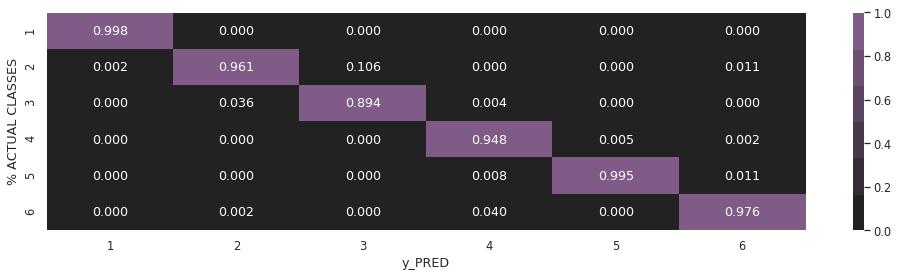

RECALL MATRIX :



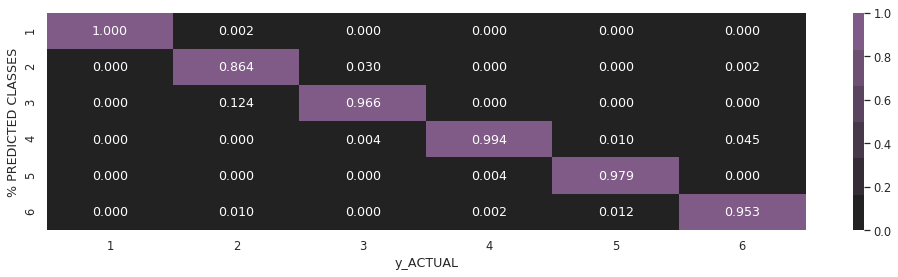

In [ ]:
retrn_heatmap_precision_recall_matrix(df_con_matrix_Log_Reg)

***

#  2. LINEAR SVM:

In [ ]:
pipe = Pipeline([('normalizer', Normalizer()), ('lr_svc', LinearSVC(tol=0.00005))])

lr_svc__C = [0.125, 0.5, 1, 2, 8, 16]

param_grid1 = {'lr_svc__C': lr_svc__C}

grid_lr_svc = GridSearchCV(pipe, param_grid1, cv = 3, return_train_score=True)

In [ ]:
data = X_train
labels = y_train

%time grid_lr_svc.fit(data, labels)

CPU times: user 1min 20s, sys: 2.15 s, total: 1min 22s
Wall time: 1min 19s


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('normalizer',
                                        Normalizer(copy=True, norm='l2')),
                                       ('lr_svc',
                                        LinearSVC(C=1.0, class_weight=None,
                                                  dual=True, fit_intercept=True,
                                                  intercept_scaling=1,
                                                  loss='squared_hinge',
                                                  max_iter=1000,
                                                  multi_class='ovr',
                                                  penalty='l2',
                                                  random_state=None, tol=5e-05,
                                                  verbose=0))],
                                verbose=False),
             iid='warn', n_jobs=No

In [ ]:
grid = grid_lr_svc
df_cv_scores_lr_svc = retrn_cv_report(grid)
df_cv_scores_lr_svc

,mean_train_score,mean_test_score,diff_train_test,std_dev_train,std_dev_test,params
0,92.764135,89.173014,3.591121,0.834134,1.363416,{'lr_svc__C': 0.125}
1,95.695209,91.186072,4.509137,0.657159,1.620263,{'lr_svc__C': 0.5}
2,97.007735,92.178999,4.828736,0.365990,1.734103,{'lr_svc__C': 1}
3,97.816942,92.995103,4.821839,0.144922,1.838826,{'lr_svc__C': 2}
4,98.857448,93.960827,4.896621,0.044230,1.678929,{'lr_svc__C': 8}
5,99.075091,94.246464,4.828627,0.025105,1.656046,{'lr_svc__C': 16}


In [ ]:
best_clf = df_cv_scores_lr_svc.loc[5]['params']
best_clf

{'lr_svc__C': 16}

In [ ]:
lr_svc_clf = LinearSVC(C = 16, tol=0.00005)
lr_svc_clf.fit(X_train, y_train)

LinearSVC(C=16, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=5e-05,
          verbose=0)

In [ ]:
y_pred_test = lr_svc_clf.predict(X_test)

df_con_matrix_lr_svc_clf = retrn_confusion_matrix(y_test, y_pred_test)
df_con_matrix_lr_svc_clf

,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,correct_preds,pred_total,actual_total,precision,recall
actual_1,537,0,0,0,0,0,537,539,537,0.996289,1.000000
actual_2,2,406,78,0,0,5,406,412,491,0.985437,0.826884
actual_3,0,6,526,0,0,0,526,604,532,0.870861,0.988722
actual_4,0,0,0,495,0,1,495,509,496,0.972495,0.997984
actual_5,0,0,0,2,413,5,413,414,420,0.997585,0.983333
actual_6,0,0,0,12,1,458,458,469,471,0.976546,0.972399


PRECISION MATRIX :



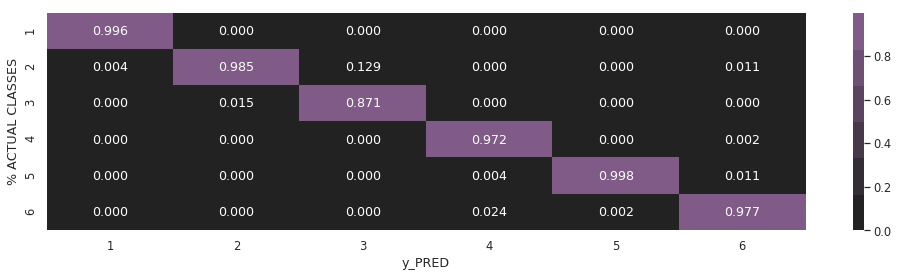

RECALL MATRIX :



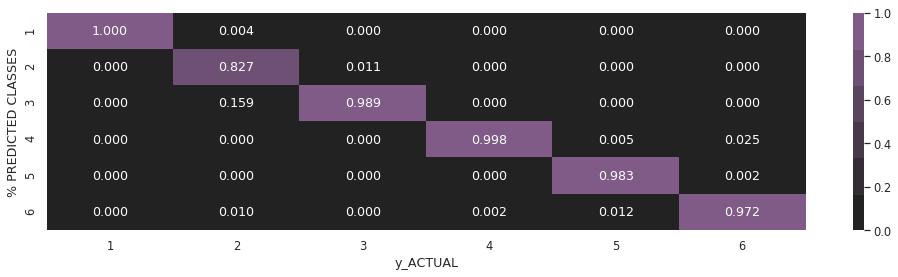

In [ ]:
retrn_heatmap_precision_recall_matrix(df_con_matrix_lr_svc_clf)

***

# 3.  KERNEL SVM

In [ ]:
pipe = Pipeline([('normalizer', Normalizer()), ('svc', SVC(kernel= 'rbf'))])

svc__C = [2, 8, 16]
svc__gamma = [0.007, 0.125, 2]

param_grid1 = {'svc__C' : svc__C, 'svc__gamma' : svc__gamma}

grid_svc = GridSearchCV(pipe, param_grid1, cv = 3, return_train_score=True, n_jobs=-1)

In [ ]:
data = X_train
labels = y_train

%time grid_svc.fit(data, labels)

CPU times: user 4.48 s, sys: 118 ms, total: 4.6 s
Wall time: 6min 15s


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('normalizer',
                                        Normalizer(copy=True, norm='l2')),
                                       ('svc',
                                        SVC(C=1.0, cache_size=200,
                                            class_weight=None, coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='auto_deprecated',
                                            kernel='rbf', max_iter=-1,
                                            probability=False,
                                            random_state=None, shrinking=True,
                                            tol=0.001, verbose=False))],
                                verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'svc__C': [2, 8, 16], 'svc__gamma': [

In [ ]:
grid = grid_svc
df_cv_scores_svc = retrn_cv_report(grid)
df_cv_scores_svc

,mean_train_score,mean_test_score,diff_train_test,std_dev_train,std_dev_test,params
0,67.593768,66.852557,0.741211,0.725430,2.825095,"{'svc__C': 2, 'svc__gamma': 0.007}"
1,93.008917,89.377040,3.631877,0.737796,1.451593,"{'svc__C': 2, 'svc__gamma': 0.125}"
2,98.456187,93.416757,5.039430,0.051341,1.728520,"{'svc__C': 2, 'svc__gamma': 2}"
3,86.786508,84.616431,2.170077,1.561161,1.061545,"{'svc__C': 8, 'svc__gamma': 0.007}"
4,96.518144,91.743743,4.774401,0.529722,1.746265,"{'svc__C': 8, 'svc__gamma': 0.125}"
5,99.258714,94.151251,5.107463,0.062973,1.411805,"{'svc__C': 8, 'svc__gamma': 2}"
6,90.961903,88.275299,2.686603,0.755978,1.016961,"{'svc__C': 16, 'svc__gamma': 0.007}"
7,97.660524,92.859086,4.801438,0.185491,1.774994,"{'svc__C': 16, 'svc__gamma': 0.125}"
8,99.496754,94.368879,5.127875,0.047883,1.116020,"{'svc__C': 16, 'svc__gamma': 2}"


In [ ]:
best_clf = df_cv_scores_svc.loc[8]['params']
best_clf

{'svc__C': 16, 'svc__gamma': 2}

In [ ]:
y_pred_test = grid_svc.predict(X_test)

df_con_matrix_svc_clf = retrn_confusion_matrix(y_test, y_pred_test)
df_con_matrix_svc_clf

,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,correct_preds,pred_total,actual_total,precision,recall
actual_1,537,0,0,0,0,0,537,537,537,1.000000,1.000000
actual_2,0,440,49,0,0,2,440,452,491,0.973451,0.896130
actual_3,0,12,520,0,0,0,520,569,532,0.913884,0.977444
actual_4,0,0,0,488,3,5,488,509,496,0.958743,0.983871
actual_5,0,0,0,5,396,19,396,399,420,0.992481,0.942857
actual_6,0,0,0,16,0,455,455,481,471,0.945946,0.966030


PRECISION MATRIX :



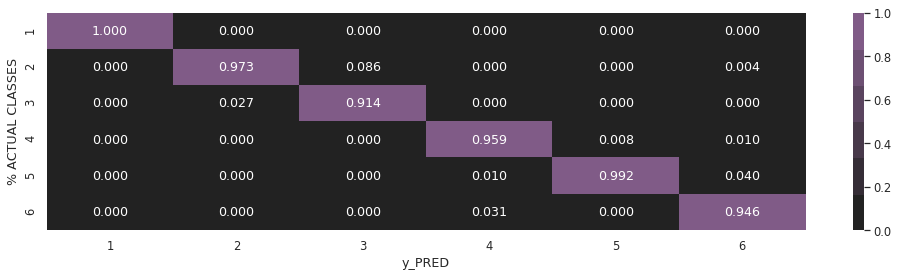

RECALL MATRIX :



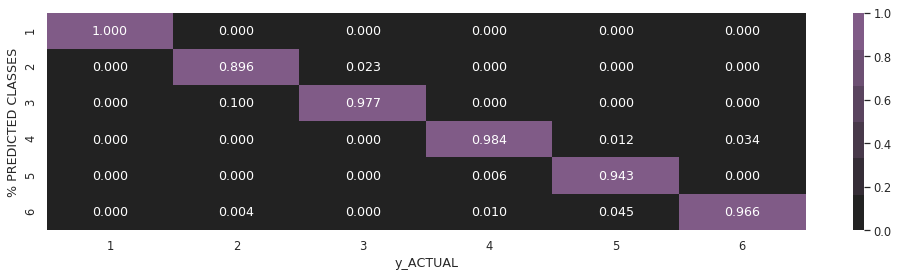

In [ ]:
retrn_heatmap_precision_recall_matrix(df_con_matrix_svc_clf)

***

# 4. RANDOM FOREST:

In [ ]:
pipe = Pipeline([('RF', RandomForestClassifier(class_weight = 'balanced'))])

param_grid1 = {'RF__n_estimators'      : np.arange(10,201,20),
               'RF__max_depth'         : np.arange(3,15,2)}

grid_RF = GridSearchCV(pipe, param_grid1, cv = 3, return_train_score=True, n_jobs = -1)

In [ ]:
data = X_train
labels = y_train

%time grid_RF.fit(data, labels)

CPU times: user 10.9 s, sys: 107 ms, total: 11 s
Wall time: 11min 57s


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('RF',
                                        RandomForestClassifier(bootstrap=True,
                                                               class_weight='balanced',
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               min_impurity_decrease=0.0,
                                                               min_impurity_split=None,
                                                               min_samples_leaf=1,
                                                               min_samples_split=2,
                 

In [ ]:
grid = grid_RF
df_cv_scores_RF = retrn_cv_report(grid)
df_cv_scores_RF

,mean_train_score,mean_test_score,diff_train_test,std_dev_train,std_dev_test,params
0,88.955560,84.983678,3.971882,1.105011,2.400740,"{'RF__max_depth': 3, 'RF__n_estimators': 10}"
1,88.935269,85.677367,3.257902,1.445707,2.109908,"{'RF__max_depth': 3, 'RF__n_estimators': 30}"
2,91.253909,87.976061,3.277848,0.460678,1.627180,"{'RF__max_depth': 3, 'RF__n_estimators': 50}"
3,90.825610,87.282372,3.543237,0.302862,1.410444,"{'RF__max_depth': 3, 'RF__n_estimators': 70}"
4,91.213154,87.894450,3.318703,0.321215,1.316241,"{'RF__max_depth': 3, 'RF__n_estimators': 90}"
5,91.526023,87.772035,3.753989,0.653419,1.803234,"{'RF__max_depth': 3, 'RF__n_estimators': 110}"
6,91.709714,88.397715,3.311999,0.077783,1.013036,"{'RF__max_depth': 3, 'RF__n_estimators': 130}"
7,91.165540,88.044070,3.121471,0.370631,1.377683,"{'RF__max_depth': 3, 'RF__n_estimators': 150}"
8,91.723436,88.696953,3.026482,0.251825,0.920771,"{'RF__max_depth': 3, 'RF__n_estimators': 170}"
9,91.172243,88.152884,3.019360,0.877689,1.367175,"{'RF__max_depth': 3, 'RF__n_estimators': 190}"


In [ ]:
df_cv_scores_RF[df_cv_scores_RF.diff_train_test < 5]

,mean_train_score,mean_test_score,diff_train_test,std_dev_train,std_dev_test,params
0,88.955560,84.983678,3.971882,1.105011,2.400740,"{'RF__max_depth': 3, 'RF__n_estimators': 10}"
1,88.935269,85.677367,3.257902,1.445707,2.109908,"{'RF__max_depth': 3, 'RF__n_estimators': 30}"
2,91.253909,87.976061,3.277848,0.460678,1.627180,"{'RF__max_depth': 3, 'RF__n_estimators': 50}"
3,90.825610,87.282372,3.543237,0.302862,1.410444,"{'RF__max_depth': 3, 'RF__n_estimators': 70}"
4,91.213154,87.894450,3.318703,0.321215,1.316241,"{'RF__max_depth': 3, 'RF__n_estimators': 90}"
5,91.526023,87.772035,3.753989,0.653419,1.803234,"{'RF__max_depth': 3, 'RF__n_estimators': 110}"
6,91.709714,88.397715,3.311999,0.077783,1.013036,"{'RF__max_depth': 3, 'RF__n_estimators': 130}"
7,91.165540,88.044070,3.121471,0.370631,1.377683,"{'RF__max_depth': 3, 'RF__n_estimators': 150}"
8,91.723436,88.696953,3.026482,0.251825,0.920771,"{'RF__max_depth': 3, 'RF__n_estimators': 170}"
9,91.172243,88.152884,3.019360,0.877689,1.367175,"{'RF__max_depth': 3, 'RF__n_estimators': 190}"


In [ ]:
best_clf = df_cv_scores_RF[df_cv_scores_RF.diff_train_test < 5].loc[15]['params']
best_clf

{'RF__max_depth': 5, 'RF__n_estimators': 110}

In [ ]:
RF_clf = RandomForestClassifier(max_depth = 5, n_estimators = 110, class_weight = 'balanced')
RF_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=110, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [ ]:
y_pred_test = RF_clf.predict(X_test)

df_con_matrix_RF_clf = retrn_confusion_matrix(y_test, y_pred_test)
df_con_matrix_RF_clf

,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,correct_preds,pred_total,actual_total,precision,recall
actual_1,537,0,0,0,0,0,537,537,537,1.000000,1.000000
actual_2,0,425,66,0,0,0,425,497,491,0.855131,0.865580
actual_3,0,72,460,0,0,0,460,526,532,0.874525,0.864662
actual_4,0,0,0,482,12,2,482,580,496,0.831034,0.971774
actual_5,0,0,0,52,317,51,317,335,420,0.946269,0.754762
actual_6,0,0,0,46,6,419,419,472,471,0.887712,0.889597


PRECISION MATRIX :



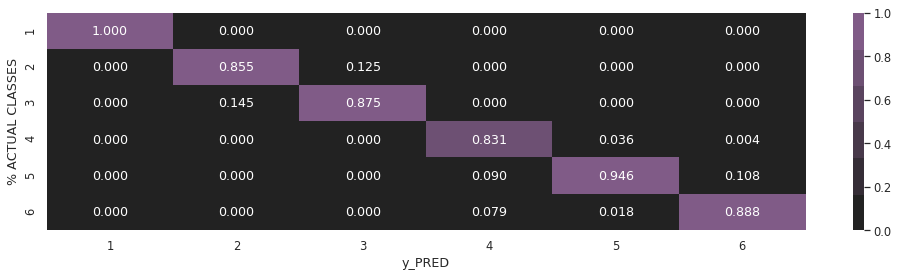

RECALL MATRIX :



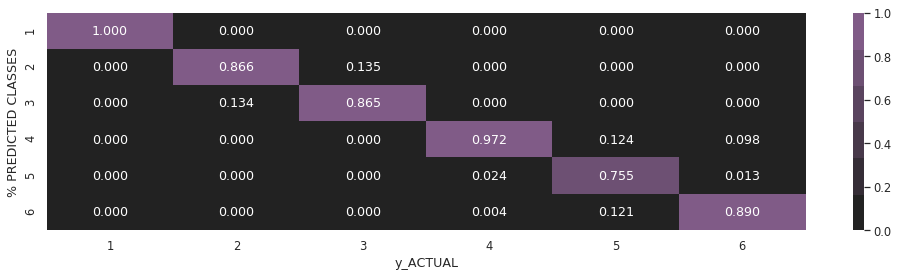

In [ ]:
retrn_heatmap_precision_recall_matrix(df_con_matrix_RF_clf)

***

# 5.  GRADIENT BOOSTED DECISION TREES:

In [ ]:
pipe = Pipeline([('GBDT', GradientBoostingClassifier())])

param_grid1 = {'GBDT__n_estimators'      : np.arange(50, 90, 10),
               'GBDT__max_depth'         : np.arange(5, 8, 1)}

grid_GBDT = GridSearchCV(pipe, param_grid1, cv = 3, return_train_score=True, n_jobs = -1)

In [ ]:
data = X_train
labels = y_train

%time grid_GBDT.fit(data, labels)

CPU times: user 4min 24s, sys: 145 ms, total: 4min 24s
Wall time: 1h 24min 46s


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('GBDT',
                                        GradientBoostingClassifier(criterion='friedman_mse',
                                                                   init=None,
                                                                   learning_rate=0.1,
                                                                   loss='deviance',
                                                                   max_depth=3,
                                                                   max_features=None,
                                                                   max_leaf_nodes=None,
                                                                   min_impurity_decrease=0.0,
                                                                   min_impurity_split=None,
                                                                   min_sam

In [ ]:
grid = grid_GBDT
df_cv_scores_GBDT = retrn_cv_report(grid)
df_cv_scores_GBDT

,mean_train_score,mean_test_score,diff_train_test,std_dev_train,std_dev_test,params
0,100.0,89.662677,10.337323,0.0,2.786430,"{'GBDT__max_depth': 5, 'GBDT__n_estimators': 50}"
1,100.0,90.070729,9.929271,0.0,2.409967,"{'GBDT__max_depth': 5, 'GBDT__n_estimators': 60}"
2,100.0,90.274755,9.725245,0.0,2.129902,"{'GBDT__max_depth': 5, 'GBDT__n_estimators': 70}"
3,100.0,90.070729,9.929271,0.0,2.208837,"{'GBDT__max_depth': 5, 'GBDT__n_estimators': 80}"
4,100.0,89.241023,10.758977,0.0,2.864980,"{'GBDT__max_depth': 6, 'GBDT__n_estimators': 50}"
5,100.0,89.703482,10.296518,0.0,2.989288,"{'GBDT__max_depth': 6, 'GBDT__n_estimators': 60}"
6,100.0,89.309032,10.690968,0.0,3.053964,"{'GBDT__max_depth': 6, 'GBDT__n_estimators': 70}"
7,100.0,89.309032,10.690968,0.0,3.342461,"{'GBDT__max_depth': 6, 'GBDT__n_estimators': 80}"
8,100.0,87.785637,12.214363,0.0,2.586119,"{'GBDT__max_depth': 7, 'GBDT__n_estimators': 50}"
9,100.0,88.084875,11.915125,0.0,2.362237,"{'GBDT__max_depth': 7, 'GBDT__n_estimators': 60}"


In [ ]:
best_clf = df_cv_scores_GBDT.loc[2]['params']
best_clf

{'GBDT__max_depth': 5, 'GBDT__n_estimators': 70}

In [ ]:
GBDT_clf = GradientBoostingClassifier(max_depth = 5, n_estimators = 70)
GBDT_clf.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=70,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
y_pred_test = GBDT_clf.predict(X_test)

df_con_matrix_GBDT_clf = retrn_confusion_matrix(y_test, y_pred_test)
df_con_matrix_GBDT_clf

,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,correct_preds,pred_total,actual_total,precision,recall
actual_1,537,0,0,0,0,0,537,537,537,1.000000,1.000000
actual_2,0,393,97,0,0,1,393,431,491,0.911833,0.800407
actual_3,0,36,496,0,0,0,496,599,532,0.828047,0.932331
actual_4,0,0,0,483,8,5,483,515,496,0.937864,0.973790
actual_5,0,0,6,8,370,36,370,383,420,0.966057,0.880952
actual_6,0,2,0,24,5,440,440,482,471,0.912863,0.934183


PRECISION MATRIX :



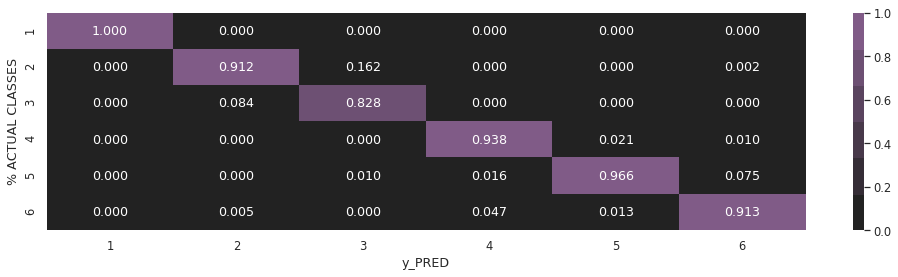

RECALL MATRIX :



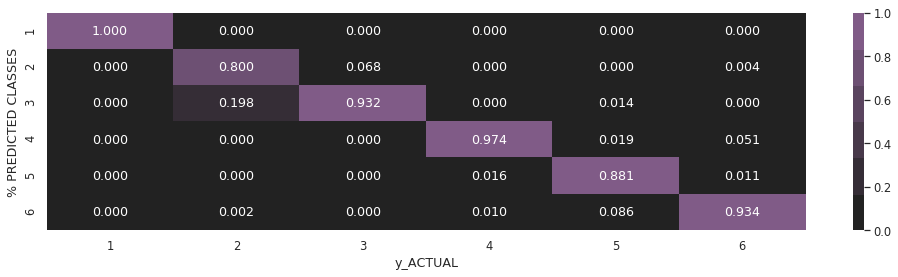

In [ ]:
retrn_heatmap_precision_recall_matrix(df_con_matrix_GBDT_clf)

***

## PERFORMANCE COMPARISON:

In [ ]:
models = 'Log_Reg Lin_SVM RBF_SVM Rand_Forest GBDT'.split()
Test_accuracy = [94.355277, 94.246464, 94.368879, 91.281284, 90.274755]
df_compare = pd.DataFrame().assign(Models = models, Test_accuracy = Test_accuracy)
df_compare

,Models,Test_accuracy
0,Log_Reg,94.355277
1,Lin_SVM,94.246464
2,RBF_SVM,94.368879
3,Rand_Forest,91.281284
4,GBDT,90.274755


## >> RBF_SVM GIVES BEST PERFORMANCE

***